<a href="https://colab.research.google.com/github/ManGuo1130/Synergistic-effect-evaluation/blob/main/R_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install torch torch-geometric pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.5 MB/s eta 0:00:00


# 数据准备

##处理节点数据

In [4]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 加载节点特征
node_features = pd.read_csv("/content/drive/MyDrive/Modis/node_features.csv")
weights_all = pd.read_csv("/content/drive/MyDrive/Modis/weights_all.csv")

# 查看数据结构
print(node_features.head())
print(weights_all.head())

   Unnamed: 0   地市        lat         lon       协同度  常住人口  城市建设用地占市区.面积比重  \
0           1  安庆市  30.576049  116.486728  0.549207   417           15.68   
1           2  常州市  31.625341  119.637182  0.784272   528            9.62   
2           3  池州市  30.284429  117.365321  0.660851   134            1.61   
3           4  滁州市  32.544120  118.102548  0.739916   399            6.55   
4           5  杭州市  29.900238  119.469934  0.729286  1197            7.38   

   地区生产总值  人均地区生产总值  第二产业占地区生产总值的比重  第三产业占地区生产总值的比重  工业企业数  专利授权数  绿化覆盖率  \
0    2468     58684           43.23           47.04   1644   5479  39.49   
1    7805    147939           46.33           51.57   5065  41321  43.30   
2     869     64843           44.07           45.80    539   2374  46.13   
3    3032     76087           48.75           42.28   1870   8654  42.30   
4   16106    136617           29.93           68.04   5992  92399  43.36   

   OBJECTID  
0         1  
1         2  
2         3  
3         4  
4         

In [5]:
# 编码节点ID为整数索引
le = LabelEncoder()
node_features['ID_encoded'] = le.fit_transform(node_features['OBJECTID'])

# 创建ID到索引的映射
id_to_index = {id_: idx for idx, id_ in enumerate(node_features['OBJECTID'])}

In [6]:
print(id_to_index)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26}


In [7]:
# 准备节点特征矩阵
feature_columns = [
    '常住人口', '城市建设用地占市区.面积比重', '地区生产总值',
    '人均地区生产总值', '第二产业占地区生产总值的比重',
    '第三产业占地区生产总值的比重', '工业企业数', '专利授权数',
    '绿化覆盖率'
]

In [8]:
X = node_features[feature_columns].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float)

In [9]:
print(X)

tensor([[-0.4836,  0.5847, -0.6946, -1.5759, -0.0449, -0.6489, -0.8534, -0.9024,
         -1.5415],
        [-0.2507, -0.2169, -0.0059,  1.1647,  0.4802, -0.0193,  0.3622,  0.0792,
          0.1763],
        [-1.0775, -1.2764, -0.9010, -1.3868,  0.0974, -0.8213, -1.2461, -0.9874,
          1.4523],
        [-0.5214, -0.6230, -0.6219, -1.0415,  0.8901, -1.3106, -0.7731, -0.8154,
         -0.2745],
        [ 1.1533, -0.5132,  1.0653,  0.8171, -2.2975,  2.2701,  0.6916,  1.4780,
          0.2034],
        [ 0.6077,  3.0939,  0.2833, -0.0485, -1.3304,  1.2999, -0.6736,  0.0719,
         -0.4143],
        [-0.6515, -0.4325, -0.6001, -0.4430,  1.0357, -0.7907, -0.0902, -0.5674,
          1.5425],
        [-0.2234,  0.3069, -0.3021, -0.2293,  1.4270, -0.8171,  0.8238, -0.0949,
         -0.8967],
        [ 0.1229, -0.7923, -0.4061, -1.3105, -0.8358,  0.8884,  0.2073,  0.1100,
         -0.6172],
        [-0.9054,  0.2064, -0.7309, -0.2762,  0.7343, -0.5641, -1.0347, -0.8380,
          1.5199],


In [10]:
# 准备目标变量（协同度）
y = torch.tensor(node_features['协同度'].values, dtype=torch.float).unsqueeze(1)

print(y)

tensor([[0.5492],
        [0.7843],
        [0.6609],
        [0.7399],
        [0.7293],
        [0.6852],
        [0.7373],
        [0.7180],
        [0.7326],
        [0.7303],
        [0.8068],
        [0.7315],
        [0.7429],
        [0.8088],
        [0.7640],
        [0.7647],
        [0.7240],
        [0.7559],
        [0.7059],
        [0.6741],
        [0.7913],
        [0.7221],
        [0.7767],
        [0.7872],
        [0.7936],
        [0.7640],
        [0.8117]])


## 构建图数据结果

In [11]:
# 映射ID到索引
weights_all['from_idx'] = weights_all['from'].map(id_to_index)
weights_all['to_idx'] = weights_all['to'].map(id_to_index)

In [12]:
# 处理关系类型
relation_le = LabelEncoder()
weights_all['relation_encoded'] = relation_le.fit_transform(weights_all['relation'])

In [13]:
# 准备边索引和边类型
edge_index = torch.tensor(weights_all[['from_idx', 'to_idx']].values, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(weights_all['relation_encoded'].values, dtype=torch.long)

In [14]:
print(edge_index)

tensor([[ 0,  0,  0,  ..., 26, 26, 26],
        [ 2,  3,  4,  ..., 20, 22, 25]])


In [15]:
print(edge_type)
max(edge_type)

tensor([5, 5, 5,  ..., 2, 2, 2])


tensor(8)

In [ ]:
# 准备边权重
# edge_weight = torch.tensor(weights_all['weights'].values, dtype=torch.float)

In [ ]:
# print(edge_weight)

tensor([2.7339e-01, 1.1664e-02, 0.0000e+00,  ..., 3.7748e-02, 1.5243e-03,
        1.6362e-04])


In [16]:
# 创建图数据对象
data = Data(x=X, edge_index=edge_index, edge_type=edge_type, y=y)

print(data)

Data(x=[27, 9], edge_index=[2, 4509], y=[27, 1], edge_type=[4509])


# 定义R-GCN模型

In [17]:
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

## 尝试1 - 加权RGCN卷积层

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim

# 自定义加权 RGCN 卷积层
class WeightedRGCNConv(RGCNConv):
    def forward(self, x, edge_index, edge_type, edge_weight=None):
        self.edge_weight = edge_weight
        return super().forward(x, edge_index, edge_type)

    def message(self, x_j, edge_weight=None):
        if edge_weight is not None:
            return x_j * edge_weight.view(-1, 1)  # 加权消息
        return x_j

In [ ]:
# 定义 RGCN 模型
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = WeightedRGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = WeightedRGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type, edge_weight=None):
        # 第一层卷积
        x = self.conv1(x, edge_index, edge_type, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # 第二层卷积
        x = self.conv2(x, edge_index, edge_type, edge_weight=edge_weight)
        return x

In [ ]:
print(f"data.x shape: {data.x.shape}")  # 节点特征矩阵
print(f"data.edge_index shape: {data.edge_index.shape}")  # 边索引矩阵
print(f"data.edge_type shape: {data.edge_type.shape}")  # 边类型索引
print(f"data.edge_attr shape: {data.edge_attr.shape}")  # 边权重
print(f"data.y shape: {data.y.shape}")  # 节点标签

data.x shape: torch.Size([27, 9])
data.edge_index shape: torch.Size([2, 4509])
data.edge_type shape: torch.Size([4509])
data.edge_attr shape: torch.Size([4509])
data.y shape: torch.Size([27, 1])


In [ ]:
# 定义模型参数
in_channels = 9
hidden_channels = 16
out_channels = 1 # 回归任务
num_relations = len(torch.unique(data.edge_type)) # relation_le 是一个示例的关系标签编码器

In [ ]:
# 实例化模型
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

In [ ]:
# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim

# 自定义加权 RGCN 卷积层
class WeightedRGCNConv(RGCNConv):
    def forward(self, x, edge_index, edge_type, edge_weight=None):
        self.edge_weight = edge_weight
        return super().forward(x, edge_index, edge_type)

    def message(self, x_j, edge_type_ptr, edge_weight=None):
        if edge_weight is not None:
            return x_j * edge_weight.view(-1, 1)  # 加权消息
        return x_j

# 定义 RGCN 模型
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = WeightedRGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = WeightedRGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type, edge_weight=None):
        # 第一层卷积
        x = self.conv1(x, edge_index, edge_type, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # 第二层卷积
        x = self.conv2(x, edge_index, edge_type, edge_weight=edge_weight)
        return x

# 定义模型参数
in_channels = 9  # 节点特征维度
hidden_channels = 16
out_channels = 1  # 回归任务输出维度
num_relations = len(torch.unique(data.edge_type))  # 边类型数量

# 实例化模型
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

# 将模型和数据移动到设备（如果有GPU）
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = model.to(device)
#data = data.to(device)

# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练函数
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        # 模型调用，传入所需参数
        out = model(
            x=data.x,
            edge_index=data.edge_index,
            edge_type=data.edge_type,
            edge_weight=data.edge_attr  # 将 edge_attr 作为 edge_weight 传递
        )
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# 训练模型
print("开始训练模型...")
train(model, data, optimizer, criterion, epochs=100)

开始训练模型...
Epoch 10, Loss: 2.2501
Epoch 20, Loss: 0.4326
Epoch 30, Loss: 0.1994
Epoch 40, Loss: 0.2053
Epoch 50, Loss: 0.1205
Epoch 60, Loss: 0.4176
Epoch 70, Loss: 0.2764
Epoch 80, Loss: 0.0786
Epoch 90, Loss: 0.1281
Epoch 100, Loss: 0.0265


in_channels = X.shape[1]

确定输入特征的维度。
X 是之前准备好的节点特征张量，形状为 [num_nodes, num_features]。
X.shape[1] 获取特征的维度，即num_features，作为in_channels。
hidden_channels = 16

设置隐藏层的特征维度为16。
这是一个经验性选择，可以根据数据和模型表现进行调整。
out_channels = 1 # 预测协同度

设置输出层的特征维度为1，用于回归任务中预测每个节点的协同度。
num_relations = len(relation_le.classes_)

确定关系类型的数量。
relation_le 是之前定义并拟合的LabelEncoder对象，用于编码边的关系类型。
relation_le.classes_ 返回所有的关系类型，每种关系类型对应一个唯一的类别。
len(relation_le.classes_) 计算关系类型的总数，作为RGCNConv层中num_relations的参数。
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

使用之前定义的RGCN类实例化一个R-GCN模型对象。
参数解释：
in_channels: 输入特征维度，从节点特征矩阵X中获取。
hidden_channels: 隐藏层的特征维度，设置为16。
out_channels: 输出特征维度，设置为1，用于回归任务。
num_relations: 关系类型的数量，确保模型能区分不同类型的边。


开始评估模型...
测试损失: 0.0056
均方误差 (MSE): 0.0056
决定系数 (R²): -0.8762


<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  plt.tight_layout()
<ipyth

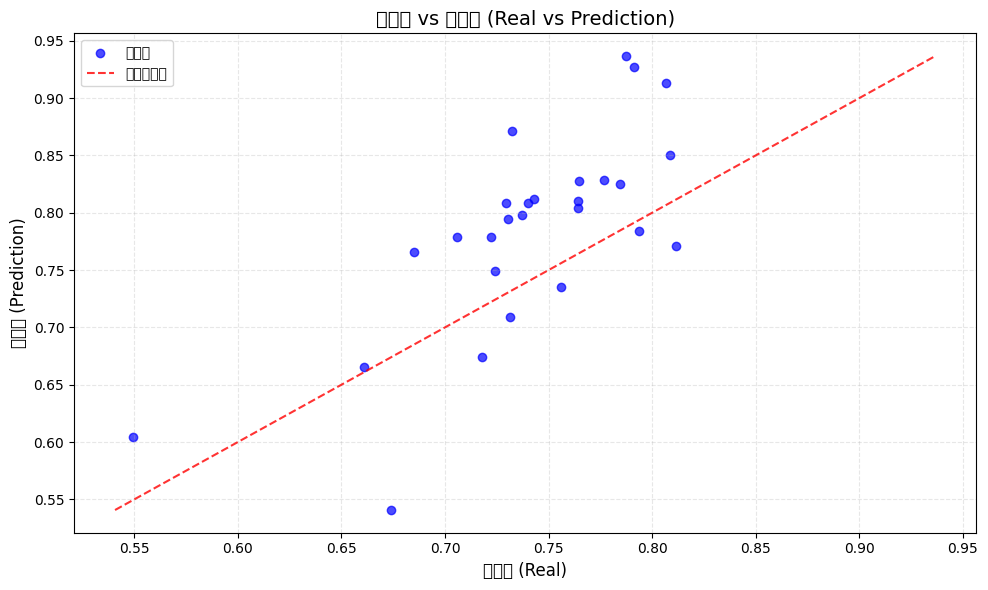


详细预测结果:
节点ID	真实值	预测值	误差
0	0.5492	0.6047	0.0555
1	0.7843	0.8255	0.0412
2	0.6609	0.6656	0.0048
3	0.7399	0.8089	0.0689
4	0.7293	0.8085	0.0792
5	0.6852	0.7654	0.0801
6	0.7373	0.7982	0.0608
7	0.7180	0.6739	0.0441
8	0.7326	0.8716	0.1390
9	0.7303	0.7942	0.0639
10	0.8068	0.9130	0.1062
11	0.7315	0.7094	0.0221
12	0.7429	0.8119	0.0690
13	0.8088	0.8504	0.0416
14	0.7640	0.8038	0.0398
15	0.7647	0.8274	0.0628
16	0.7240	0.7494	0.0254
17	0.7559	0.7354	0.0205
18	0.7059	0.7789	0.0730
19	0.6741	0.5407	0.1335
20	0.7913	0.9275	0.1362
21	0.7221	0.7788	0.0567
22	0.7767	0.8287	0.0521
23	0.7872	0.9368	0.1495
24	0.7936	0.7837	0.0099
25	0.7640	0.8106	0.0466
26	0.8117	0.7711	0.0406

模型已保存到: rgcn_model.pth


In [ ]:
# 评估模型
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 评估模型
print("\n开始评估模型...")
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    # 修改模型调用，确保传入所有必要参数
    predictions = model(
        x=data.x,
        edge_index=data.edge_index,
        edge_type=data.edge_type,
        edge_weight=data.edge_attr  # 确保传入边权重
    )

    # 计算测试损失
    loss = criterion(predictions, data.y)
    print(f'测试损失: {loss.item():.4f}')

    # 转换为 NumPy 数组进行评估
    preds = predictions.cpu().detach().numpy().flatten()  # 确保从 GPU 转到 CPU
    targets = data.y.cpu().detach().numpy().flatten()

    # 计算评估指标
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f'均方误差 (MSE): {mse:.4f}')
    print(f'决定系数 (R²): {r2:.4f}')

    # 可视化预测结果
    plt.figure(figsize=(10, 6))

    # 绘制散点图
    plt.scatter(targets, preds, alpha=0.7, label='预测点', color='blue')

    # 绘制对角线
    min_val = min(targets.min(), preds.min())
    max_val = max(targets.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', label='理想预测线', alpha=0.8)

    # 添加标签和标题
    plt.xlabel('真实值 (Real)', fontsize=12)
    plt.ylabel('预测值 (Prediction)', fontsize=12)
    plt.title('真实值 vs 预测值 (Real vs Prediction)', fontsize=14)
    plt.legend(fontsize=10)

    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.3)

    # 调整布局
    plt.tight_layout()

    # 显示图像
    plt.show()

    # 输出详细的预测结果
    print("\n详细预测结果:")
    print("节点ID\t真实值\t预测值\t误差")
    for i in range(len(targets)):
        error = abs(targets[i] - preds[i])
        print(f"{i}\t{targets[i]:.4f}\t{preds[i]:.4f}\t{error:.4f}")

# 保存模型（可选）
model_path = 'rgcn_model.pth'
torch.save(model.state_dict(), model_path)
print(f"\n模型已保存到: {model_path}")

In [ ]:
print(f"data.x shape: {data.x.shape}")
print(f"data.edge_index shape: {data.edge_index.shape}")
print(f"data.edge_type shape: {data.edge_type.shape}")
print(f"data.edge_attr shape: {data.edge_attr.shape if hasattr(data, 'edge_attr') else '无'}")
print(f"data.y shape: {data.y.shape}")

data.x shape: torch.Size([27, 9])
data.edge_index shape: torch.Size([2, 4509])
data.edge_type shape: torch.Size([4509])
data.edge_attr shape: torch.Size([4509])
data.y shape: torch.Size([27, 1])


# 尝试2 - 验证加权值[无权重数据加入]

In [103]:
# 定义模型
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        # 第一层卷积
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        # 第二层卷积
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, data, x, edge_index, edge_type):
        # 从数据中提取特征、边索引和边类型 - 数据一一对应
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        # 第一层卷积
        x = self.conv1(x, edge_index, edge_type)
        # 激活函数
        x = F.relu(x)
        # 第二层卷积
        x = self.conv2(x, edge_index, edge_type)
        return x

In [104]:
# 模型参数
in_channels = X.shape[1] # 输入节点的维度
hidden_channels = 16  # 隐藏层节点的维度
out_channels = 1  # 预测协同度 - 输出节点特征的维度
num_relations = len(relation_le.classes_)  # 图关系的数量

In [105]:
# 实例化模型
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

In [106]:
# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [107]:
# 训练模型
x = data.x  # 节点特征
edge_index = data.edge_index  # 边索引
edge_type = data.edge_type  # 边类型

def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        out = model(data, x, edge_index, edge_type)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

train(model, data, optimizer, criterion, epochs=100)

Epoch 10, Loss: 0.6449
Epoch 20, Loss: 0.1331
Epoch 30, Loss: 0.0741
Epoch 40, Loss: 0.0182
Epoch 50, Loss: 0.0136
Epoch 60, Loss: 0.0060
Epoch 70, Loss: 0.0037
Epoch 80, Loss: 0.0024
Epoch 90, Loss: 0.0015
Epoch 100, Loss: 0.0010


# 评估模型

Test Loss: 0.0010
MSE: 0.0010, R²: 0.6614


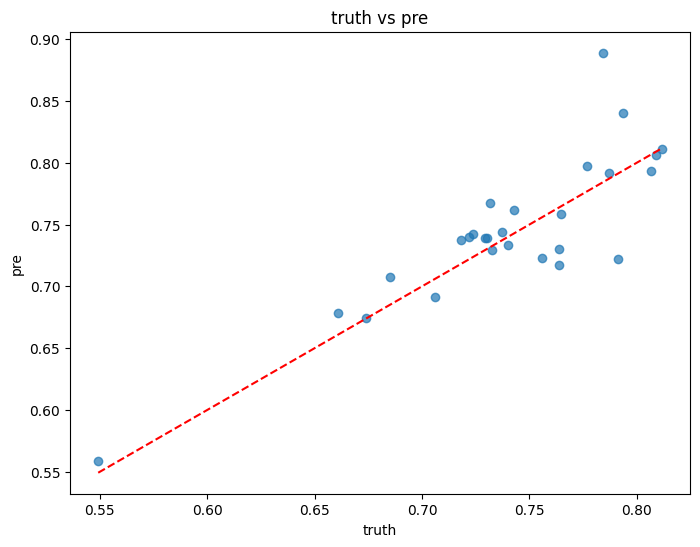

In [109]:
model.eval()
with torch.no_grad():
    predictions = model(data, x, edge_index, edge_type)
    loss = criterion(predictions, data.y)
    print(f'Test Loss: {loss.item():.4f}')

    # 转换为numpy数组
    preds = predictions.numpy().flatten()
    targets = data.y.numpy().flatten()

    # 计算MSE和R²
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f'MSE: {mse:.4f}, R²: {r2:.4f}')

    # 绘制真实值与预测值对比
    plt.figure(figsize=(8,6))
    plt.scatter(targets, preds, alpha=0.7)
    plt.xlabel('truth')
    plt.ylabel('pre')
    plt.title('truth vs pre')
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.show()

# 模型可解释性分析

## 基础分析

In [43]:
import pandas as pd

# 选择用于相关性分析的特征列
feature_columns = [
    '常住人口', '城市建设用地占市区.面积比重', '地区生产总值',
    '人均地区生产总值', '第二产业占地区生产总值的比重',
    '第三产业占地区生产总值的比重', '工业企业数', '专利授权数',
    '绿化覆盖率'
]

# 计算相关性矩阵
correlation_matrix = node_features[feature_columns].corr()

print("变量间的相关性矩阵:")
print(correlation_matrix)

变量间的相关性矩阵:
                    常住人口  城市建设用地占市区.面积比重    地区生产总值  人均地区生产总值  第二产业占地区生产总值的比重  \
常住人口            1.000000        0.596592  0.963966  0.487045       -0.676400   
城市建设用地占市区.面积比重  0.596592        1.000000  0.544133  0.291039       -0.389316   
地区生产总值          0.963966        0.544133  1.000000  0.649110       -0.624449   
人均地区生产总值        0.487045        0.291039  0.649110  1.000000       -0.224975   
第二产业占地区生产总值的比重 -0.676400       -0.389316 -0.624449 -0.224975        1.000000   
第三产业占地区生产总值的比重  0.816206        0.551662  0.783066  0.461283       -0.903936   
工业企业数           0.743263        0.307454  0.723563  0.522091       -0.155373   
专利授权数           0.905504        0.430973  0.922543  0.642838       -0.539378   
绿化覆盖率          -0.567046       -0.575076 -0.433037  0.063828        0.320798   

                第三产业占地区生产总值的比重     工业企业数     专利授权数     绿化覆盖率  
常住人口                  0.816206  0.743263  0.905504 -0.567046  
城市建设用地占市区.面积比重        0.551662  0.307454  0.430973 -0.575076  

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20303 (\N{CJK UNIFIED IDEOGRAPH-4F4F}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
  fig.canvas.draw()
/usr

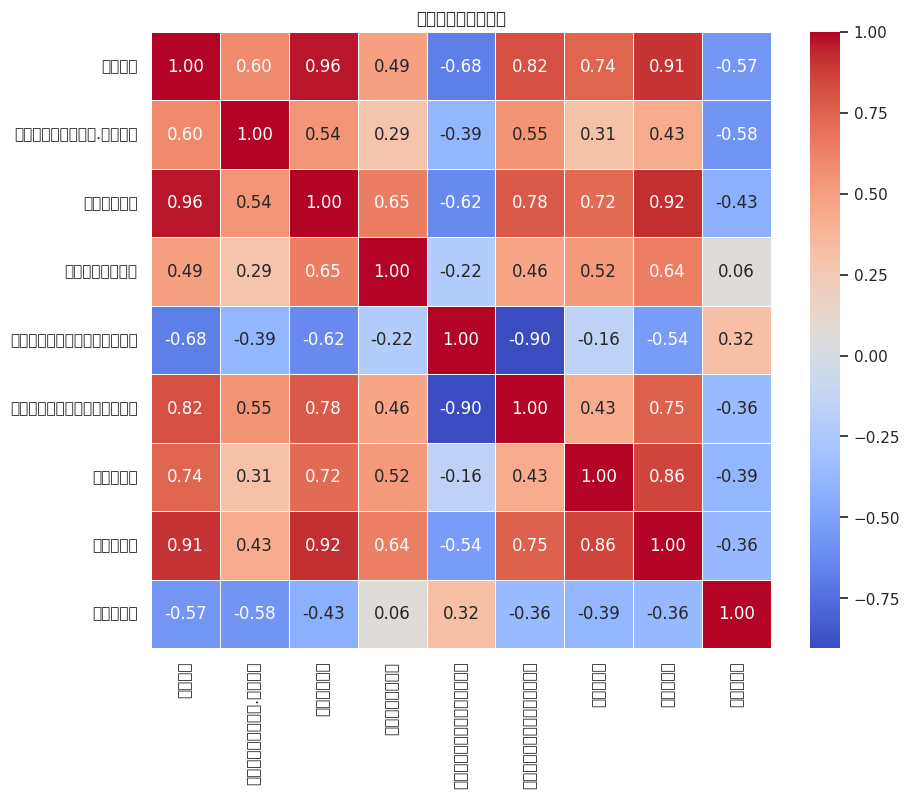

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="white")

# 绘制热力图
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('变量间相关性热力图')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 35774 (\N{CJK UNIFIED IDEOGRAPH-8BBE}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10

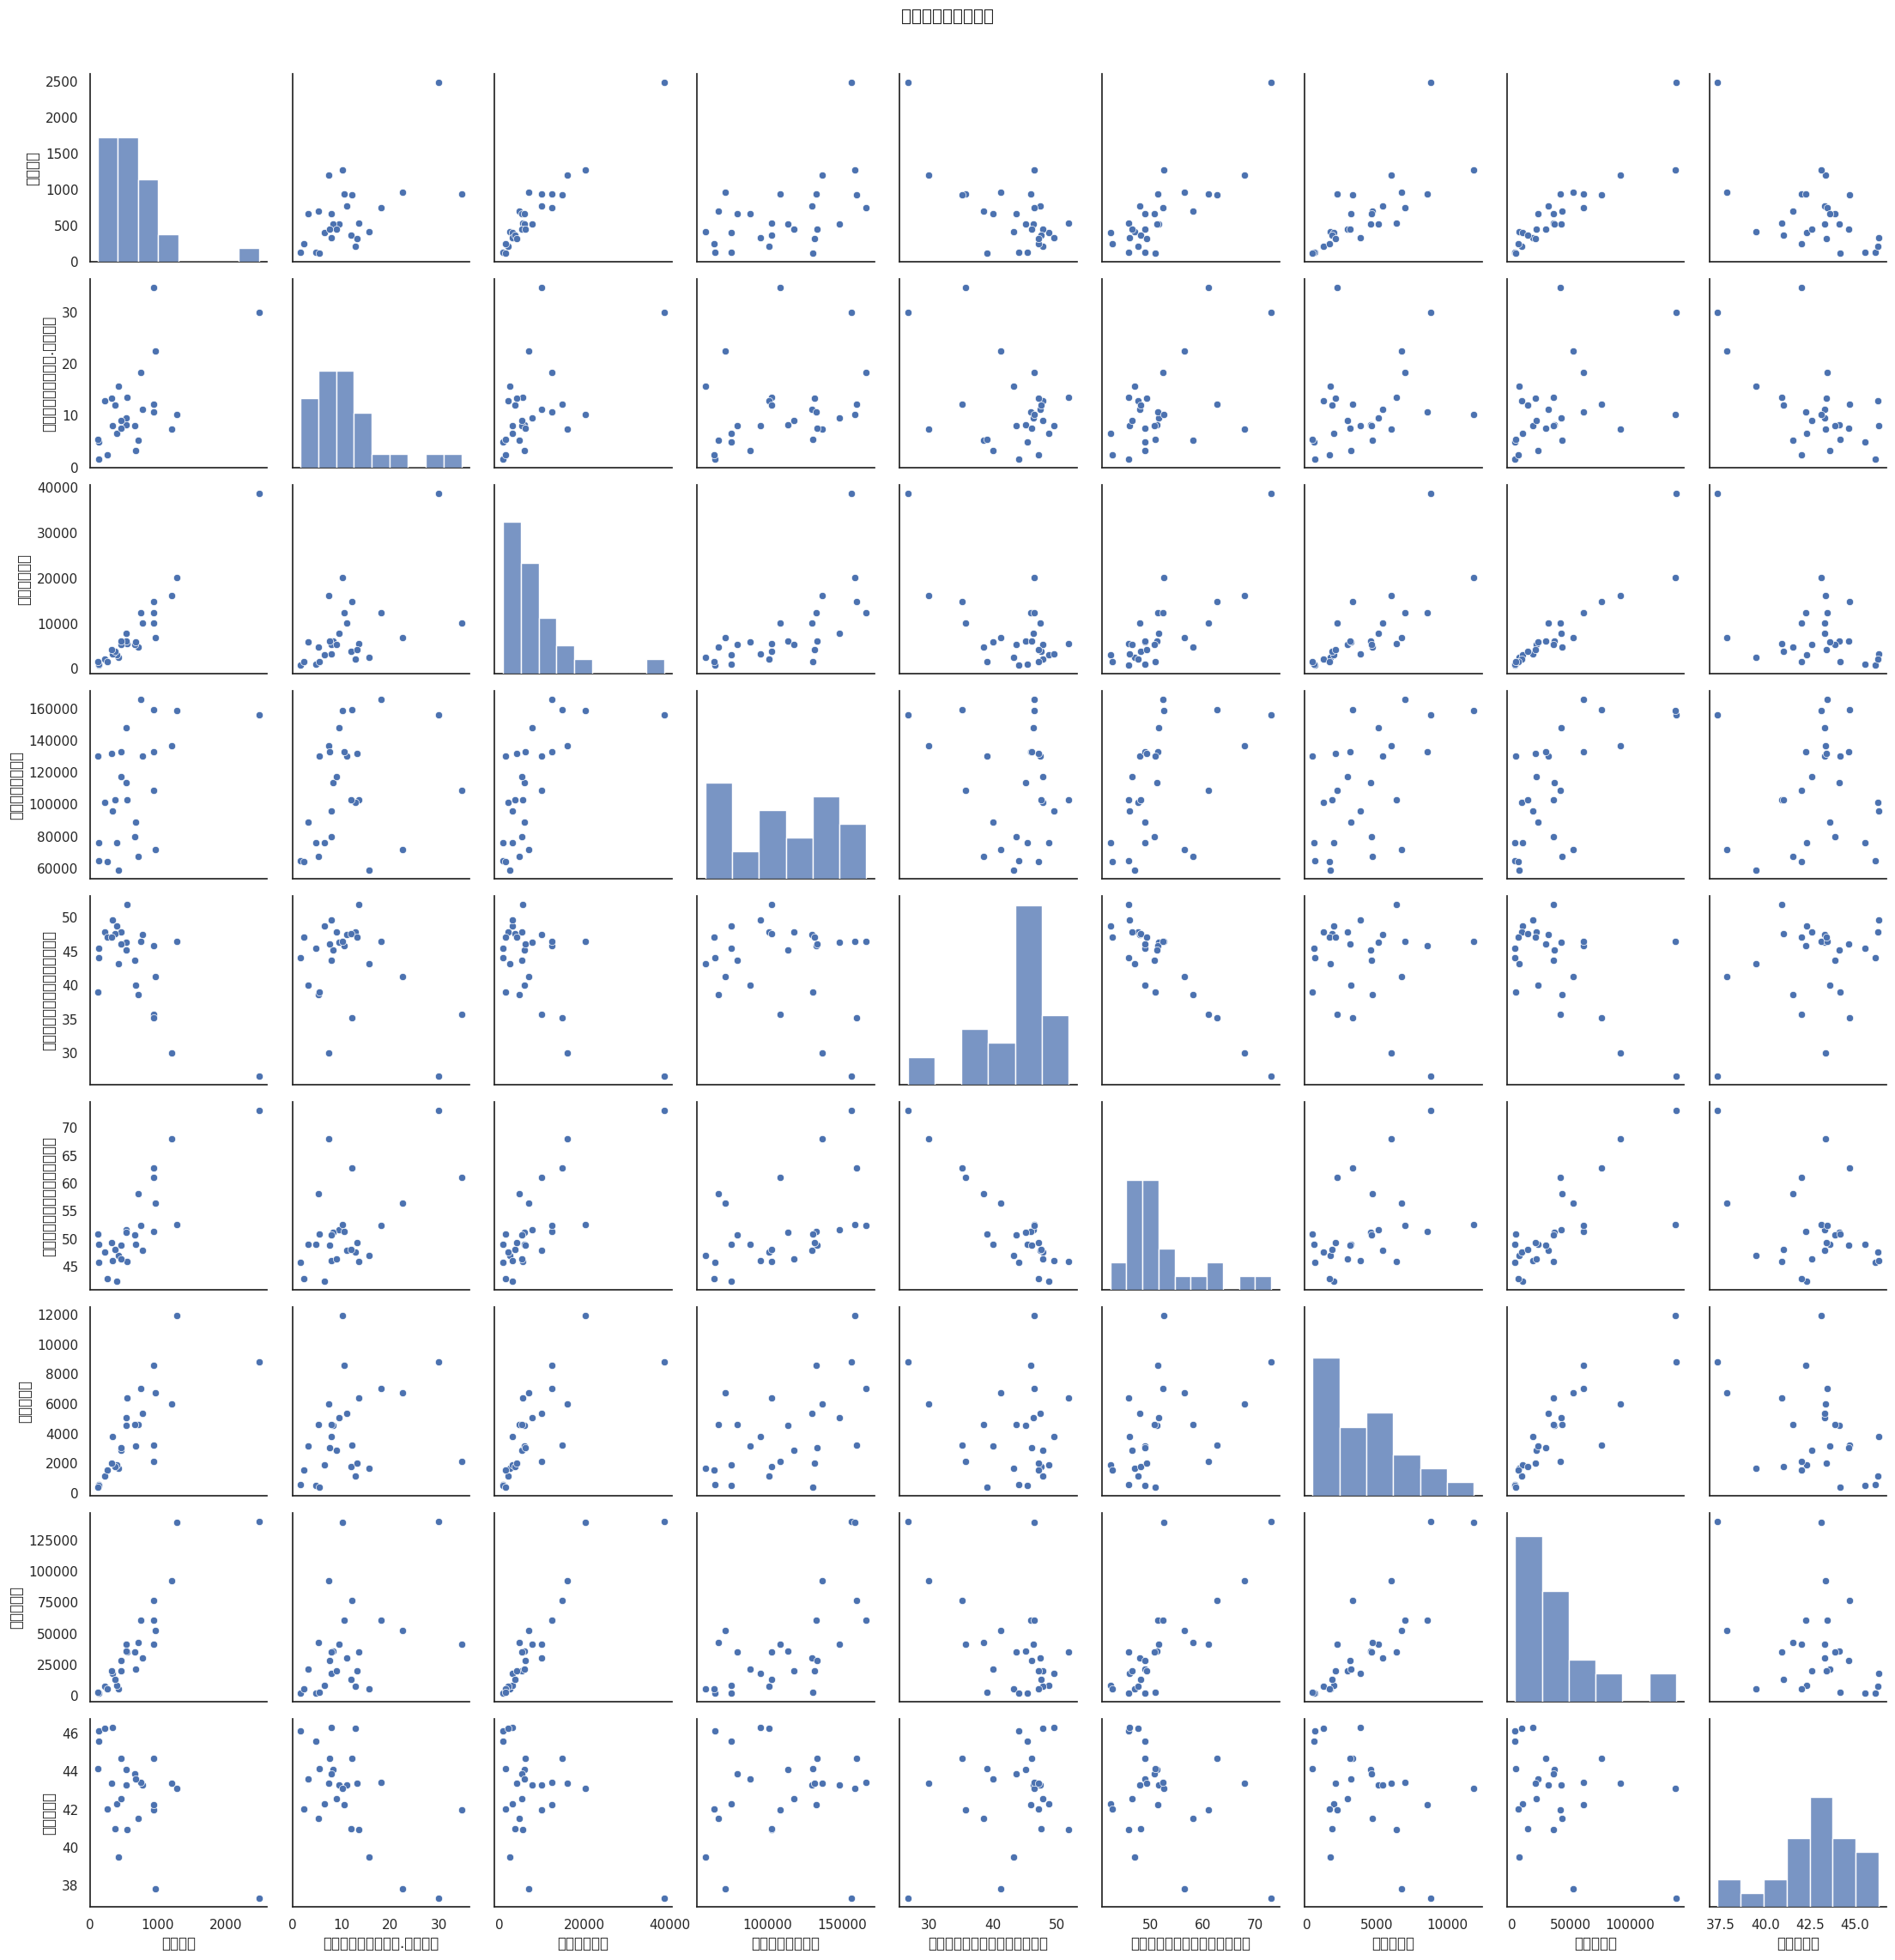

In [45]:
import seaborn as sns

# 绘制散点图矩阵
sns.pairplot(node_features[feature_columns])
plt.suptitle('变量对的散点图矩阵', y=1.02)
plt.show()

In [48]:
# 假设 'relation' 列表示不同的关系类型
relation_types = weights_all['relation'].unique()

for relation in relation_types:
    subset = weights_all[weights_all['relation'] == relation]
    from_features = node_features[node_features['OBJECTID'].isin(subset['from'])]
    to_features = node_features[node_features['OBJECTID'].isin(subset['to'])]

    # 例如，计算特定关系类型下 '地区生产总值' 的平均值
    mean_gdp = to_features['地区生产总值'].mean()
    print(f"关系类型 '{relation}' 下目标节点的平均地区生产总值: {mean_gdp:.2f}")

关系类型 'pop' 下目标节点的平均地区生产总值: 7851.00
关系类型 'urban' 下目标节点的平均地区生产总值: 7851.00
关系类型 'GDP' 下目标节点的平均地区生产总值: 7851.00
关系类型 'cGDP' 下目标节点的平均地区生产总值: 7851.00
关系类型 'sec' 下目标节点的平均地区生产总值: 7851.00
关系类型 'ter' 下目标节点的平均地区生产总值: 7851.00
关系类型 'ind' 下目标节点的平均地区生产总值: 7851.00
关系类型 'int' 下目标节点的平均地区生产总值: 7851.00
关系类型 'gre' 下目标节点的平均地区生产总值: 7851.00


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

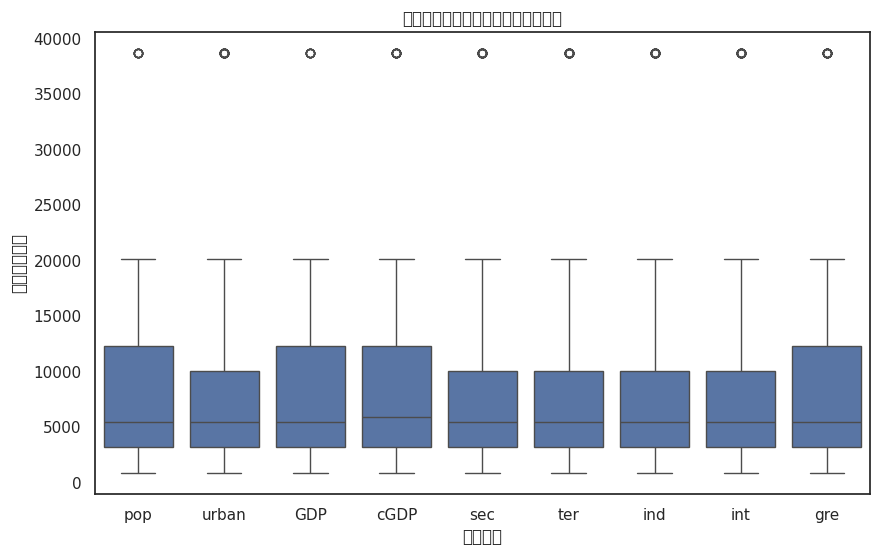

In [49]:
# 示例：不同关系类型下 '地区生产总值' 的分布
plt.figure(figsize=(10, 6))
sns.boxplot(x='relation', y='地区生产总值', data=weights_all.merge(node_features, left_on='to', right_on='OBJECTID'))
plt.title('不同关系类型下的地区生产总值分布')
plt.xlabel('关系类型')
plt.ylabel('地区生产总值')
plt.show()

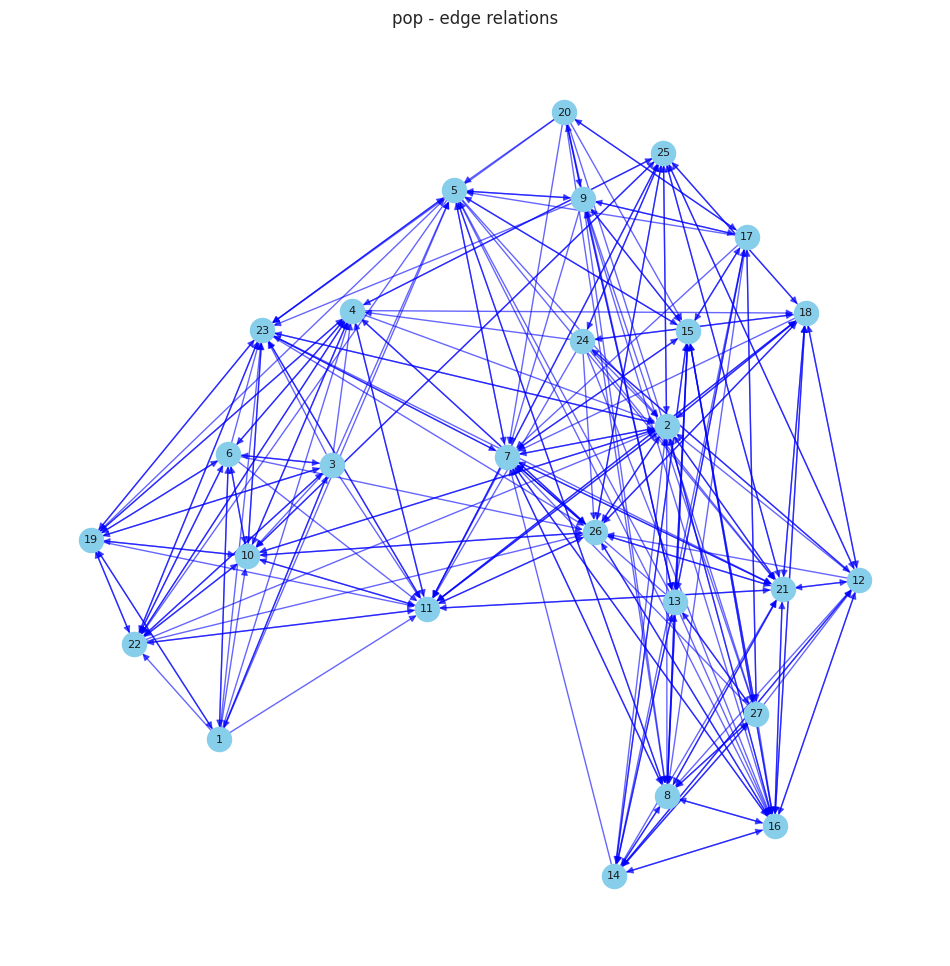

In [66]:
# 仅仅出图 - POP
import networkx as nx
import matplotlib.pyplot as plt

# 创建有向图
G = nx.DiGraph()

# 添加节点，附加特征
for idx, row in node_features.iterrows():  # 确保 node_features 是您的节点特征数据框
    G.add_node(row['OBJECTID'],  # 节点 ID
               area=row['城市建设用地占市区.面积比重'],  # 其他特征
               gdp=row['地区生产总值'],  # GDP 特征
               population=row.get('常住人口', 0),  # 常住人口特征
               coord=(row.get('lat', 0), row.get('lon', 0)))  # 坐标（可选）

# 添加边，附加关系类型和权重
for idx, row in weights_all.iterrows():  # 确保 weights_all 是您的边的权重数据框
    if row['relation'] == 'pop':  # 只关注边类型为“常驻人口”的边
        G.add_edge(row['from'],  # 边的起始节点 ID
                   row['to'],  # 边的目标节点 ID
                   relation=row['relation'],  # 边的关系类型
                   weight=row['weights'])  # 边的权重（可选）

# 筛选出与常住人口相关的节点
# 这里我们只关注与“常住人口”边相连的节点
relevant_nodes = set()
for u, v, data in G.edges(data=True):
    if data['relation'] == 'pop':
        relevant_nodes.add(u)
        relevant_nodes.add(v)

# 创建一个新的图，只包含相关节点和边
H = G.subgraph(relevant_nodes).copy()

# 检查是否有相关节点
if len(H.nodes) == 0:
    print("没有找到符合条件的节点，请检查数据。")
else:
    # 绘制网络图
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(H, k=0.5)

    # 根据关系类型选择颜色
    edge_colors = ['blue' if data['relation'] == 'pop' else 'black' for _, _, data in H.edges(data=True)]

    # 绘制节点
    nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')

    # 绘制边
    nx.draw_networkx_edges(H, pos, edge_color=edge_colors, alpha=0.6)

    # 绘制标签
    nx.draw_networkx_labels(H, pos, font_size=8)

    plt.title('pop - edge relations')
    plt.axis('off')
    plt.show()

## GNNExplainer深度分析

In [130]:
import torch
import torch.nn.functional as F
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, Explanation
from torch_geometric.data import Data

In [111]:
# 创建图数据对象
data = Data(x=X, edge_index=edge_index, edge_type=edge_type, y=y)

print(data)

Data(x=[27, 9], edge_index=[2, 4509], y=[27, 1], edge_type=[4509])


In [112]:
# 定义模型 --- 不执行，仅用于分析
#class RGCN(torch.nn.Module):
#    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
#        super(RGCN, self).__init__()
        # 第一层卷积
#        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        # 第二层卷积
#        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

#    def forward(self, data, x, edge_index, edge_type):
        # 从数据中提取特征、边索引和边类型 - 数据一一对应
#        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        # 第一层卷积
#        x = self.conv1(x, edge_index, edge_type)
        # 激活函数
#        x = F.relu(x)
        # 第二层卷积
#        x = self.conv2(x, edge_index, edge_type)
#        return x


#  out = model(data, x, edge_index, edge_type)

In [113]:
# 获取模型的输出
model.eval()
with torch.no_grad():
    # 从 data 中提取 x, edge_index, 和 edge_type
    x = data.x  # 节点特征
    edge_index = data.edge_index  # 边索引
    edge_type = data.edge_type  # 边类型

    # 调用模型的 forward 方法
    out = model(data, x, edge_index, edge_type)  # 传入 data, x, edge_index, edge_type

[可解释性学习模块](https://blog.csdn.net/ARPOSPF/article/details/131724177)

**可解释性学习模块**
1. 功能性：可以提供一些方法来解释模型的预测结果，边权重和节点重要性
2. 模块核心框架：
  * 解释器（Explainer）类：一个用于实例级解释的PyG可解释性模块的包装器；
  * 解释（Explanation）类：封装解释程序输出的类
  * 解释器算法（ExplainerAlgorithm）类：解释器使用的解释性算法在给定训练实例的情况下生成解释
  * 度量（metric）包：使用解释（Explanation）输出以及GNN模型 /ground truth的评估指标来评估解释性










In [133]:
# 解释器设置
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
  #  node_mask_type='attributes',
  #  edge_mask_type='object',
     node_mask_type= 'attributes',
     edge_mask_type= None,
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

node_mask_type 的可能值
None:

含义：不在节点上应用任何掩码。
用途：选择此选项时，解释器将不会对节点特征进行任何修改或屏蔽。这意味着所有节点的特征都将被保留，解释将基于完整的节点特征进行。
object:

含义：将屏蔽每个节点。
用途：选择此选项时，解释器将为每个节点生成一个掩码，指示该节点是否应被屏蔽。掩码的值通常是一个二进制值（0 或 1），其中 1 表示该节点被保留，0 表示该节点被屏蔽。这种方法可以帮助理解特定节点对模型输出的影响。
common_attributes:

含义：将掩盖每个特征。
用途：选择此选项时，解释器将为每个特征生成一个掩码，指示该特征是否应被屏蔽。这样可以帮助分析特征对模型输出的贡献，了解哪些特征在决策中是重要的。
attributes:

含义：将屏蔽所有节点上的每个特征。
用途：选择此选项时，解释器将为每个节点的每个特征生成一个掩码。这意味着每个节点的每个特征都可以被单独屏蔽，从而提供更细粒度的解释。这种方法可以帮助深入理解特定特征在不同节点上的重要性。

解释代码:
*   model - 我要解释的模型
*   algorithm - GNNExplainer - 指定用于生成解释的算法
*   explanation_type='model'-'model'- 表示生成模型级别的解释，通常用于理解模型的整体行为和决策过程
*   node_mask_type='attributes' - 'attributes' 表示节点掩码将基于节点的特征进行生成。这意味着解释将关注节点特征对模型输出的影响。  
*   edge_mask_type='object' - 'object' 表示边掩码将基于边的对象（例如边的类型或特征）进行生成。这意味着解释将关注边的特征对模型输出的影响。
*   model_config=dict(...) - 这个字典包含了模型的具体配置参数，影响解释的生成方式。
*   mode='regression' - 指定模型的任务类型
*   task_level='node' - 'node' 表示解释是针对节点级别的。这意味着解释将关注单个节点的特征和关系，而不是整个图的特征
*   return_type='raw' - 对于回归任务，通常返回原始值


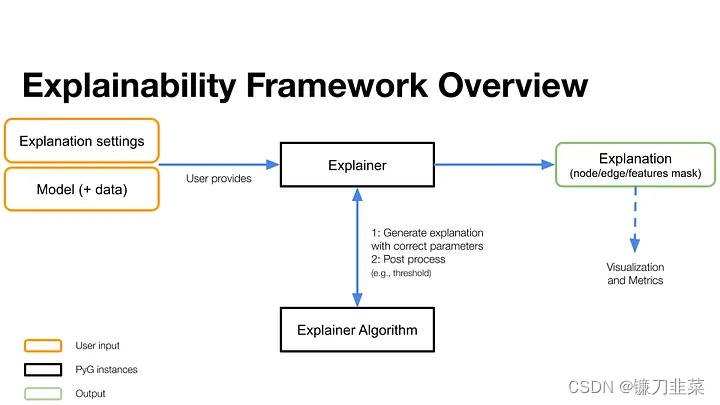




In [120]:
# 创建图数据对象
data = Data(x=X, edge_index=edge_index, edge_type=edge_type, y=y)

print(data)

Data(x=[27, 9], edge_index=[2, 4509], y=[27, 1], edge_type=[4509])


In [ ]:
# 定义模型 --- 不执行，仅用于分析
#class RGCN(torch.nn.Module):
#    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
#        super(RGCN, self).__init__()
        # 第一层卷积
#        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        # 第二层卷积
#        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

#    def forward(self, data, x, edge_index, edge_type):
        # 从数据中提取特征、边索引和边类型 - 数据一一对应
#        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        # 第一层卷积
#        x = self.conv1(x, edge_index, edge_type)
        # 激活函数
#        x = F.relu(x)
        # 第二层卷积
#        x = self.conv2(x, edge_index, edge_type)
#        return x


#  out = model(data, x, edge_index, edge_type)

In [88]:
print(data.x)

tensor([[-0.4836,  0.5847, -0.6946, -1.5759, -0.0449, -0.6489, -0.8534, -0.9024,
         -1.5415],
        [-0.2507, -0.2169, -0.0059,  1.1647,  0.4802, -0.0193,  0.3622,  0.0792,
          0.1763],
        [-1.0775, -1.2764, -0.9010, -1.3868,  0.0974, -0.8213, -1.2461, -0.9874,
          1.4523],
        [-0.5214, -0.6230, -0.6219, -1.0415,  0.8901, -1.3106, -0.7731, -0.8154,
         -0.2745],
        [ 1.1533, -0.5132,  1.0653,  0.8171, -2.2975,  2.2701,  0.6916,  1.4780,
          0.2034],
        [ 0.6077,  3.0939,  0.2833, -0.0485, -1.3304,  1.2999, -0.6736,  0.0719,
         -0.4143],
        [-0.6515, -0.4325, -0.6001, -0.4430,  1.0357, -0.7907, -0.0902, -0.5674,
          1.5425],
        [-0.2234,  0.3069, -0.3021, -0.2293,  1.4270, -0.8171,  0.8238, -0.0949,
         -0.8967],
        [ 0.1229, -0.7923, -0.4061, -1.3105, -0.8358,  0.8884,  0.2073,  0.1100,
         -0.6172],
        [-0.9054,  0.2064, -0.7309, -0.2762,  0.7343, -0.5641, -1.0347, -0.8380,
          1.5199],


In [125]:
target = out[node_index]

print(target)

tensor([0.7934])


In [132]:
# 节点设置 + 用户输入
node_index = 10  # 要解释的节点索引
target = out[node_index]

# 调用解释器
explanation = explainer(data.x, data.edge_index, data.edge_type, target)

# 打印解释结果
print(explanation)

Explanation(x=[27, 9], edge_index=[2, 4509], edge_attr=[4509], y=[1])


## 尝试3 - 不加权 + 不加去边类别

节点特征掩码 (Node Mask):
tensor([[0.1450, 0.1517, 0.1377, 0.1429, 0.1304, 0.1503, 0.1442, 0.1390, 0.1440],
        [0.1404, 0.1482, 0.1388, 0.1388, 0.1248, 0.1385, 0.1315, 0.1566, 0.1344],
        [0.1318, 0.1366, 0.1415, 0.1353, 0.1267, 0.1452, 0.1438, 0.1566, 0.1342],
        [0.1485, 0.1422, 0.1459, 0.1348, 0.1513, 0.1453, 0.1491, 0.1458, 0.1534],
        [0.1465, 0.1395, 0.1481, 0.1479, 0.1507, 0.1488, 0.1467, 0.1449, 0.1225],
        [0.1250, 0.1564, 0.1441, 0.1408, 0.1380, 0.1412, 0.1464, 0.1403, 0.1663],
        [0.1458, 0.1350, 0.1478, 0.1396, 0.1467, 0.1451, 0.1496, 0.1451, 0.1416],
        [0.1330, 0.1493, 0.1442, 0.1298, 0.1582, 0.1592, 0.1444, 0.1294, 0.1440],
        [0.1273, 0.1521, 0.1455, 0.1538, 0.1318, 0.1442, 0.1261, 0.1321, 0.1446],
        [0.1407, 0.1494, 0.1472, 0.1369, 0.1509, 0.1581, 0.1387, 0.1394, 0.1266],
        [0.1451, 0.1494, 0.1546, 0.1355, 0.1388, 0.1465, 0.1253, 0.1502, 0.1229],
        [0.1302, 0.1376, 0.1493, 0.1535, 0.1264, 0.1303, 0.1357, 0.1512, 0.131

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

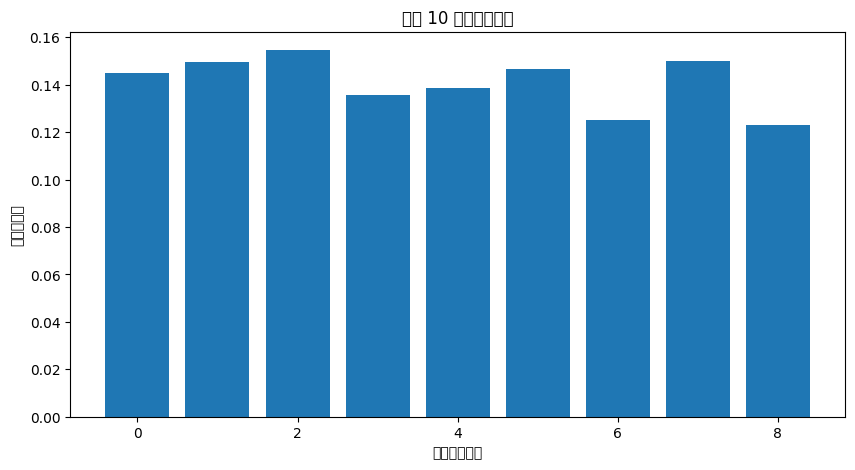

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25513 (\N{CJK UNIFIED IDEOGRAPH-63A9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


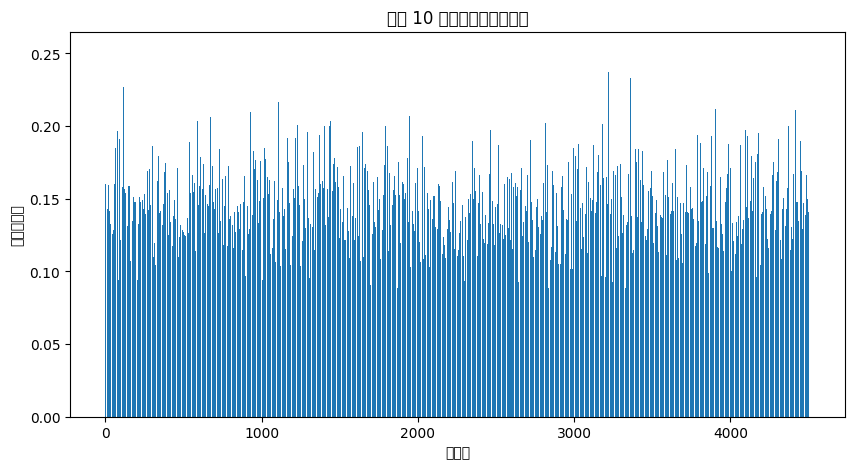

In [149]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
import matplotlib.pyplot as plt

# 定义 GCN 模型
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# 假设你已经有了一个图数据对象 `data`
# data = ...

# 初始化模型（根据你的数据调整输入参数）
in_channels = data.num_node_features  # 节点特征维度
hidden_channels = 16
out_channels = 1  # 根据任务类型调整输出维度
model = GCN(in_channels, hidden_channels, out_channels)

# 加载训练好的模型参数（如果有）
# model.load_state_dict(torch.load('path_to_model.pth'))
model.eval()

# 获取模型输出
with torch.no_grad():
    out = model(data.x, data.edge_index)  # 只传递 x 和 edge_index

# 选择要解释的节点索引
node_index = 10  # 例如，选择节点 10

# 获取该节点的预测值
target = out[node_index]  # 取出该节点的预测值

# 使用 GNNExplainer 进行解释
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',  # 屏蔽所有节点上的每个特征
    edge_mask_type='object',       # 屏蔽每条边
    model_config=dict(
        mode='regression',        # 根据你的任务调整 'regression' 或 'classification'
        task_level='node',        # 解释节点级别的预测
        return_type='raw',        # 返回原始输出
    ),
)

# 调用解释器
explanation = explainer(data.x, data.edge_index, target=target, index=node_index)

# 打印解释结果
print("节点特征掩码 (Node Mask):")
print(explanation.node_mask)

print("\n边特征掩码 (Edge Mask):")
print(explanation.edge_mask)

# 提取特定节点的节点特征掩码
node_mask = explanation.node_mask.detach().cpu().numpy()  # 形状: (num_nodes, num_features)
node_mask_specific = node_mask[node_index]  # 形状: (num_features,)

# 可视化特定节点的节点特征掩码
plt.figure(figsize=(10, 5))
plt.bar(range(len(node_mask_specific)), node_mask_specific)
plt.xlabel('节点特征索引')
plt.ylabel('重要性评分')
plt.title(f'节点 {node_index} 的特征重要性')
plt.show()

# 提取相关边的边掩码
edge_mask = explanation.edge_mask.detach().cpu().numpy()  # 形状: (num_edges,)

# 可视化边掩码
plt.figure(figsize=(10, 5))
plt.bar(range(len(edge_mask)), edge_mask)
plt.xlabel('边索引')
plt.ylabel('重要性评分')
plt.title(f'节点 {node_index} 相关边的掩码重要性')
plt.show()

## 数据集划分

In [ ]:
# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)

# 获取节点数量
num_nodes = data.num_nodes

# 定义划分比例
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [ ]:
# 确认比例总和为1
assert train_ratio + val_ratio + test_ratio == 1.0, "划分比例之和必须为1.0"

In [ ]:
train_ratio + val_ratio + test_ratio

In [ ]:
# 生成随机索引
indices = np.random.permutation(num_nodes)
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# 创建掩码
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# 将掩码添加到数据对象中
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"训练集节点数: {train_mask.sum().item()}")
print(f"验证集节点数: {val_mask.sum().item()}")
print(f"测试集节点数: {test_mask.sum().item()}")

In [ ]:
def train(model, data, optimizer, criterion, epochs=100):
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # 前向传播
        out = model(data)

        # 仅计算训练集的损失
        loss = criterion(out[data.train_mask], data.y[data.train_mask])

        # 反向传播
        loss.backward()
        optimizer.step()

        # 计算验证集损失
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])

        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # 保存最佳模型
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'best_rgcn_model.pth')
            print(f'最佳模型参数已保存 (Val Loss: {best_val_loss:.4f})')

    print("训练完成。")

In [ ]:
train(model, data, optimizer, criterion, epochs=500)

# 评估模型

In [ ]:
# 加载最佳模型参数
model.load_state_dict(torch.load('best_rgcn_model.pth'))
model.eval()

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

Test Loss: 0.1056
Test MSE: 0.1056, Test R²: -52.5262


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21327 (\N{CJK UNIFIED IDEOGRAPH-534F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

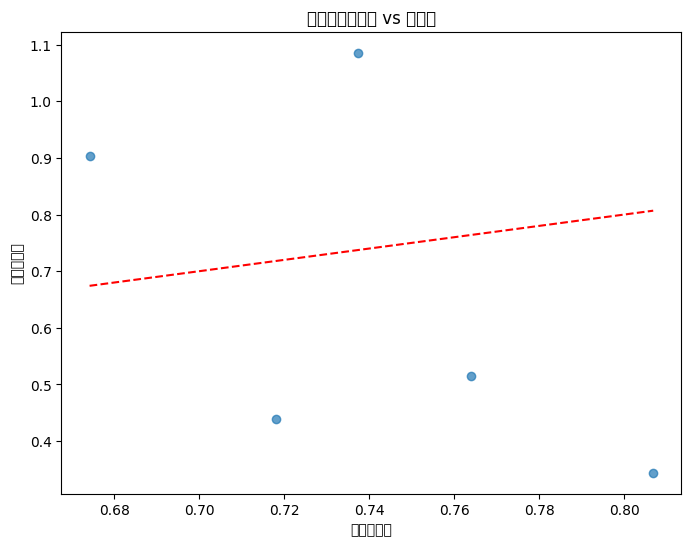

In [ ]:
with torch.no_grad():
    predictions = model(data)

    # 损失计算
    test_loss = criterion(predictions[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss.item():.4f}')

    # 转换为numpy数组
    preds = predictions[data.test_mask].numpy().flatten()
    targets = data.y[data.test_mask].numpy().flatten()

    # 计算MSE和R²
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f'Test MSE: {mse:.4f}, Test R²: {r2:.4f}')

    # 绘制真实值与预测值对比
    plt.figure(figsize=(8,6))
    plt.scatter(targets, preds, alpha=0.7)
    plt.xlabel('真实协同度')
    plt.ylabel('预测协同度')
    plt.title('测试集：真实值 vs 预测值')
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.show()

# 可解释性说明

In [ ]:
import torch
from torch_geometric.explain import GNNExplainer, Explanation
from torch_geometric.explain.config import (
    ModelConfig,
    ExplainerConfig,
    MaskType
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# 配置模型
model_config = ModelConfig(
    mode='regression',  # 因为是回归任务
    task_level='node',  # 节点级任务
    return_type='raw'   # 返回原始输出
)

# 配置解释器
explainer_config = ExplainerConfig(
    explanation_type='model',  # 直接使用字符串
    node_mask_type='attributes',  # 直接使用字符串
    edge_mask_type='object'      # 直接使用字符串
)

# 初始化解释器
explainer = GNNExplainer(
    model=model,
    epochs=100,
    lr=0.01
)

# 连接配置
explainer.connect(
    model_config=model_config,
    explainer_config=explainer_config
)


In [ ]:
explainer = GNNExplainer(
    model=model,
    epochs=100,
    lr=0.01
)

In [ ]:
def analyze_node(node_idx):
    """分析单个节点的可解释性"""
    # 生成解释
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        target=node_idx,
        model=model,
        edge_type=data.edge_type
    )

    # 打印解释对象的属性
    print("解释对象包含的属性：")
    for attr in dir(explanation):
        if not attr.startswith('_'):
            value = getattr(explanation, attr)
            if isinstance(value, (torch.Tensor, np.ndarray)):
                print(f"{attr}: shape = {value.shape}")
            else:
                print(f"{attr}: {type(value)}")

    return explanation

def visualize_explanation(explanation, node_idx, feature_names):
    """可视化解释结果"""
    # 1. 特征重要性可视化
    if hasattr(explanation, 'node_mask'):
        plt.figure(figsize=(10, 6))
        feature_imp = explanation.node_mask.detach().cpu().numpy()
        if len(feature_imp.shape) > 1:
            feature_imp = feature_imp[node_idx]

        # 归一化特征重要性
        feature_imp = (feature_imp - feature_imp.min()) / (feature_imp.max() - feature_imp.min())

        plt.bar(feature_names, feature_imp)
        plt.xticks(rotation=45, ha='right')
        plt.title(f'节点 {node_idx} 的特征重要性')
        plt.tight_layout()
        plt.show()

    # 2. 边重要性可视化
    if hasattr(explanation, 'edge_mask'):
        edge_mask = explanation.edge_mask.detach().cpu().numpy()

        G = nx.Graph()
        edge_index = data.edge_index.cpu().numpy()

        # 添加边
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            G.add_edge(int(src), int(dst))

        # 设置布局
        pos = nx.spring_layout(G)

        # 归一化边掩码
        edge_mask = (edge_mask - edge_mask.min()) / (edge_mask.max() - edge_mask.min())

        # 根据边掩码设置边的颜色和宽度
        edge_colors = []
        edge_widths = []
        threshold = 0.5  # 可以调整这个阈值

        for i, (u, v) in enumerate(G.edges()):
            if edge_mask[i] > threshold:
                edge_colors.append('red')
                edge_widths.append(2.0 * edge_mask[i])
            else:
                edge_colors.append('gray')
                edge_widths.append(0.5 * edge_mask[i])

        plt.figure(figsize=(12, 12))
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
        nx.draw_networkx_nodes(G, pos,
                             node_color=['orange' if n == node_idx else 'lightblue'
                                       for n in G.nodes()],
                             node_size=300)
        nx.draw_networkx_labels(G, pos)
        plt.title(f'节点 {node_idx} 的邻居重要性')
        plt.axis('off')
        plt.show()

In [ ]:
model.eval()

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

In [ ]:
print(model)

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)


In [ ]:
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, train_mask, y=data.y)
plt.show()

AttributeError: 'GNNExplainer' object has no attribute 'visualize_subgraph'